In [1]:
# From: https://www.kaggle.com/c/dog-breed-identification/data
# Author: Morpheus Hsieh (morpheus.hsieh@gmail.com)

from __future__ import print_function, division

import os, sys
import copy
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime
from os import listdir
from os.path import join, exists, isfile
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, utils

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.4.0+cu121
Torchvision Version:  0.19.0+cu121


In [2]:
# Params = {
#     'DataPath'    : r'D:\GitWork\dog_breed\data',
#     'OutPath'     : r'D:\GitWork\dog_breed\output',
#     'ProcPath'    : r'D:\GitWork\dog_breed\processed',
#     'PreTrainPath': r'D:\GitWork\dog_breed\pretrained',
#     'PreTrainFile': '',
#     'TestPath'    : r'D:\Dataset\dog-breed-identification\test',
#     'TrainPath'   : r'D:\Dataset\dog-breed-identification\train',
#     'CsvLabel'    : 'labels.csv',
#     'BatchSize'   : 16,
#     'FracForTrain': 0.8
# }

Params = {
    'DataPath'    : r'/home/jovyan/data/dog-breed/',
    'OutPath'     : r'/home/jovyan/output/dog-breed/',
    'ProcPath'    : r'/home/jovyan/output/dog-breed/',
    'PreTrainPath': r'/home/jovyan/models/dog-breed/',
    'PreTrainFile': r'',
    'TestPath'    : r'/home/jovyan/data/dog-breed/test/',
    'TrainPath'   : r'/home/jovyan/data/dog-breed/train/',
    'CsvLabel'    : 'labels.csv',
    'BatchSize'   : 16,
    'FracForTrain': 0.8
}


def prettyDict(dic, indent=2):
    array = []
    key_maxlen = 0
    item_cnt = 0
    item_size = len(dic)
    split_str = ': '
    
    for key, val in dic.items():
        if key_maxlen < len(str(key)): 
            key_maxlen = len(str(key))
        
        tmpstr = ''
        tmpstr += f"'{key}'" if isinstance(key, str) else f"{key}"
        tmpstr += split_str
        tmpstr += f"'{val}'" if isinstance(val, str) else f"{val}"

        item_cnt += 1
        if item_cnt < item_size: tmpstr += ','
        array.append(tmpstr)
    
    for i in range(len(array)):
        inStr = array[i]
        ary = inStr.split(split_str)
        key = ary[0].ljust(key_maxlen+2)
        val = ary[1]
        array[i] = (' '*indent) + key + ': ' + val
        
    outstr = '{\n' + '\n'.join(array) + '\n}'
    return outstr

outstr = prettyDict(Params)
print('Parameters:')
print(outstr)

Parameters:
{
  'DataPath'    : '/home/jovyan/data/dog-breed/',
  'OutPath'     : '/home/jovyan/output/dog-breed/',
  'ProcPath'    : '/home/jovyan/output/dog-breed/',
  'PreTrainPath': '/home/jovyan/models/dog-breed/',
  'PreTrainFile': '',
  'TestPath'    : '/home/jovyan/data/dog-breed/test',
  'TrainPath'   : '/home/jovyan/data/dog-breed/train',
  'CsvLabel'    : 'labels.csv',
  'BatchSize'   : 16,
  'FracForTrain': 0.8
}


In [3]:
# Read breed information from csv
DataPath = Params.get('DataPath')
csv_labels = Params.get('CsvLabel')
f_abspath = join(DataPath, csv_labels)

df_labels = pd.read_csv(f_abspath)

print(df_labels.info())
print()
print(df_labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
from IPython.display import display
display(df_labels.head(10))

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [5]:
# Count all breeds
def countBreeds(df):
    df1 = df_labels.groupby("breed")["id"].count().reset_index(name="count")
    df1 = df1.sort_values(by='count', ascending=False).reset_index(drop=True)
    df1.insert(0, 'breed_id', df1.index)
    return df1

df_breeds = countBreeds(df_labels)
print(df_breeds.info())
print()
print(df_breeds.head())

NumClasses = int(df_breeds.shape[0])
print('\nNum classes:', NumClasses)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   breed_id  120 non-null    int64 
 1   breed     120 non-null    object
 2   count     120 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ KB
None

   breed_id                 breed  count
0         0    scottish_deerhound    126
1         1           maltese_dog    117
2         2          afghan_hound    116
3         3           entlebucher    115
4         4  bernese_mountain_dog    114

Num classes: 120


In [6]:
# Process labels

dict_bid_fw = dict(df_breeds[['breed', 'breed_id']].values)
# print(dict_bid_fw)

dict_bid_bw = dict(df_breeds[['breed_id', 'breed']].values)
# print(dict_bid_bw)

# Build processed labels file
df_data = pd.DataFrame(columns=['image', 'breed_id'])
df_data['breed_id'] = df_labels.breed.map(dict_bid_fw)

TranPath = Params['TrainPath']

df_data['image'] = df_labels.apply (
    lambda row: join(TranPath, row['id']+'.jpg') \
    if exists(join(TranPath, row['id']+'.jpg')) else None, 
    axis=1
)

print(df_data.info())
print(df_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     10222 non-null  object
 1   breed_id  10222 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.8+ KB
None
                                               image  breed_id
0  /home/jovyan/data/dog-breed/train/000bec180eb1...        42
1  /home/jovyan/data/dog-breed/train/001513dfcb2f...        72
2  /home/jovyan/data/dog-breed/train/001cdf01b096...        94
3  /home/jovyan/data/dog-breed/train/00214f311d5d...        50
4  /home/jovyan/data/dog-breed/train/0021f9ceb323...       115


In [7]:
# Create dataset

# Transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225]
    )
])

class myDataset(Dataset):

    def __init__(self, df, phase='train', frac=0.8, transform=None):
        
        num_rows = df.shape[0]
        train_len = int(float(frac) * float(num_rows))
        valid_len = num_rows - train_len
        
        # data = df.head(train_len) if phase=='train' else df.tail(valid_len)
        
        # get random image id without duplicates
        idx_ary = np.arange(len(df))
        idx_ary_rand = np.random.permutation(idx_ary) # random shuffle
        
        data_len = train_len if phase=='train' else valid_len
        data = df.loc[idx_ary_rand[:data_len]]
        
        self.images = data['image'].tolist()
        self.labels = data['breed_id'].tolist()

        self.transform = transform
        self.len = len(self.images)

    def __getitem__(self, index):
        f_abspath = self.images[index]
        img_pil = Image.open(f_abspath)

        if self.transform is not None:
            img = self.transform(img_pil)

        lbl = int(self.labels[index])
        iid = os.path.split(f_abspath)[1].replace('.jpg', '')
        
        return [img, lbl, iid]

    def __len__(self):
        return self.len
    

frac = Params['FracForTrain']

phases = ['train', 'valid']
dataSet = { 
    x: myDataset(df_data, phase=x, frac=frac, transform=transform) for x in phases 
}

BatchSize = Params['BatchSize']
dataLoader = {
    x: DataLoader(dataSet[x], batch_size=BatchSize, shuffle=True) for x in phases
}

dataSizes = { x: len(dataSet[x]) for x in phases }
print('DataSet size:', dataSizes)

trainLoader = dataLoader['train']
imgs, lbls, iids = next(iter(trainLoader))
print('\nImage shape:', imgs.size())
print('Label shape:', lbls.size())

print('\nImage iid:')
id_list = [''.join(iid) for iid in iids]
print('  '+'\n  '.join(id_list))

img = imgs[0]
print('\nImage shape:', img.shape)
print(); print(img)

print('\nLabels:', lbls[0])

DataSet size: {'train': 8177, 'valid': 2045}

Image shape: torch.Size([16, 3, 224, 224])
Label shape: torch.Size([16])

Image iid:
  d65bc49d1cf6be1fe8fd5798c4a28e08
  3d048af542545494b12fd46c06bc5a52
  68fe92544e3c171703144e0df84c964d
  b2004690624be6cb621bd557815e7638
  63021bfb22038c0e4095ada8cf691b76
  bddd13e14c54a5ca227fddcf968d99c3
  05719b998e57a11b863a322ecc7652a5
  07a0214fa84969b5256bf7d20f1b3a9b
  3efa1c5b966b6ce836b87db21f00c48b
  be390f190d4ab118992e2784b8522d50
  c36626ef165cd73783a2e760aaa2fc72
  42d2ca5eb80634db250e8b2db9f13b08
  d9f0ac78472ce66dd48364521d396835
  fc2049d582b3444ed99af4a5c13b49e5
  d8488f933f021216d7a39f6e8f1bc9c5
  bcf3f1b3f1424edece51c1275a226fd4

Image shape: torch.Size([3, 224, 224])

tensor([[[-1.0733, -0.5767,  0.3994,  ..., -1.4329, -1.4843, -1.5528],
         [-1.1075, -0.6109,  0.4337,  ..., -1.3815, -1.3987, -1.3644],
         [-1.1418, -0.6109,  0.4166,  ..., -1.4158, -1.3130, -1.2959],
         ...,
         [-0.8678, -0.8849, -0.8849,  ...

In [8]:
# Use GPU for train
use_gpu = torch.cuda.is_available()
print("use_gpu: ", use_gpu)

device = torch.device("cuda:0" if use_gpu else "cpu")
print(device)

use_gpu:  True
cuda:0


In [9]:
# Build Model
def buildModel(use_gpu, numClasses, preTrainModel=None):
    # model = models.resnet50(pretrained=True)
    # model = torchvision.models.resnet50()
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # freeze all model parameters
    for param in model.parameters():
        model.requires_grad = False

    # new final layer with 16 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, numClasses)
    
    if preTrainModel is not None:
        model.load_state_dict(preTrainModel)
        
    if use_gpu: 
        model = model.cuda()
        
    return model


TrainPath = Params['PreTrainPath']
TrainFile = Params['PreTrainFile']
f_pretrain = join(TrainPath, TrainFile)

pretrain_model = None
if exists(f_pretrain) and isfile(f_pretrain):
    pretrain_model = torch.load(join(path, fname), weights_only=True)

model = buildModel(use_gpu, NumClasses, preTrainModel=pretrain_model)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight 	 torch.Size([256])
layer1.0.bn3.bias 	 torch.Size([256])
layer1.0.bn3.running_mean 	 torch.Size([256])
layer1.0.bn3.running_var 	 torch.Size([256])
layer1.0.bn3.num

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0, 1]}]


In [12]:
# Train and validate Model

def train_model(loader, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history  = {
        'train_acc': [],
        'train_los': [],
        'valid_acc': [],
        'valid_los': []
    }
    
    dataset_sizes = {
        'train': len(loader['train'].dataset),
        'valid': len(loader['valid'].dataset)
    }

    for epoch in range(num_epochs):
        
        for phase in ['train', 'valid']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels, iids in loader[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistic
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            data_size = dataset_sizes[phase]
            
            if phase == 'train':
                train_epoch_loss = running_loss / data_size
                train_epoch_acc  = running_corrects / data_size
            else:
                valid_epoch_loss = running_loss / data_size
                valid_epoch_acc  = running_corrects / data_size

            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        history['train_acc'].append(train_epoch_acc.item())
        history['train_los'].append(train_epoch_loss)
        history['valid_acc'].append(valid_epoch_acc.item())
        history['valid_los'].append(valid_epoch_loss)
        
        fmt_str = (
            'Epoch [{:3d}/{:3d}] train loss: {:.4f} acc: {:.4f}'
            ', valid loss: {:.4f} acc: {:.4f}'
        )
        print(fmt_str.format(
            epoch, num_epochs - 1, 
            train_epoch_loss, train_epoch_acc, valid_epoch_loss, valid_epoch_acc
        ))

    print('\nBest val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, best_acc, history

In [13]:
NumEpochs = 10
start_time = time.time()

best_model, best_acc, history = train_model(
    dataLoader, model, criterion, optimizer, exp_lr_scheduler, NumEpochs
)
    
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [  0/  9] train loss: 0.2609 acc: 0.3801, valid loss: 0.2234 acc: 0.7271
Epoch [  1/  9] train loss: 0.1871 acc: 0.6762, valid loss: 0.1572 acc: 0.7966
Epoch [  2/  9] train loss: 0.1350 acc: 0.7608, valid loss: 0.1239 acc: 0.8333
Epoch [  3/  9] train loss: 0.1018 acc: 0.8095, valid loss: 0.0968 acc: 0.8548
Epoch [  4/  9] train loss: 0.0806 acc: 0.8316, valid loss: 0.0650 acc: 0.8753
Epoch [  5/  9] train loss: 0.0683 acc: 0.8453, valid loss: 0.0588 acc: 0.8753
Epoch [  6/  9] train loss: 0.0601 acc: 0.8551, valid loss: 0.0584 acc: 0.8856
Epoch [  7/  9] train loss: 0.0553 acc: 0.8667, valid loss: 0.0571 acc: 0.8817
Epoch [  8/  9] train loss: 0.0551 acc: 0.8654, valid loss: 0.0534 acc: 0.8841
Epoch [  9/  9] train loss: 0.0543 acc: 0.8661, valid loss: 0.0516 acc: 0.8846

Best val Acc: 0.885575
Training time:   9.260539 minutes


{ 'train_acc': [ 0.38009047508239746,
                 0.6761648654937744,
                 0.7607924342155457,
                 0.8094655275344849,
                 0.8316007852554321,
                 0.8452977538108826,
                 0.85508131980896,
                 0.8666992783546448,
                 0.8653540015220642,
                 0.866087794303894],
  'train_los': [ 0.2608551130881443,
                 0.18712770494225703,
                 0.13502974078374458,
                 0.10182344710839994,
                 0.08058808861493744,
                 0.06832890985384392,
                 0.06012564698539212,
                 0.0553163445395334,
                 0.05506136692341491,
                 0.05426710446772809],
  'valid_acc': [ 0.7271393537521362,
                 0.7965770363807678,
                 0.8332518339157104,
                 0.8547677397727966,
                 0.8753055930137634,
                 0.8753055930137634,
                 0.88557457923

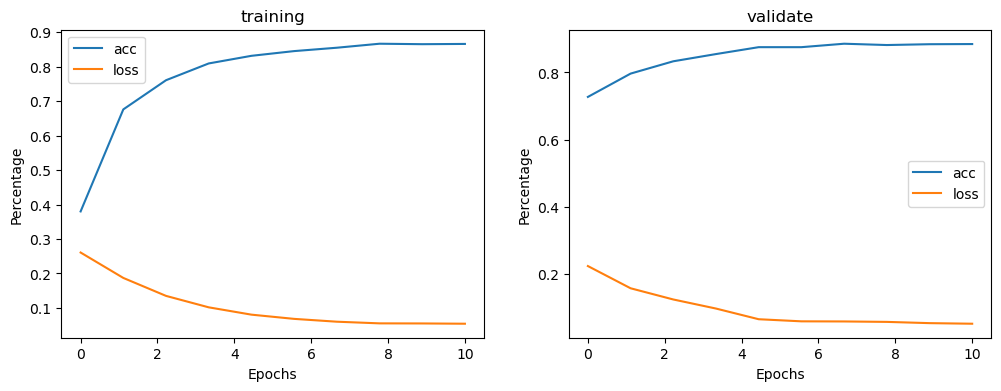

In [14]:
import matplotlib.pyplot as plt
from pprint import pprint

pprint(history, indent=2)

train_acc = history['train_acc']
train_los = history['train_los']
valid_acc = history['valid_acc']
valid_los = history['valid_los']

# for i in range(len(history)):
#     train_acc.append(history[i]['train_acc'])
#     train_los.append(history[i]['train_loss'])
#     valid_acc.append(history[i]['valid_acc'])
#     valid_los.append(history[i]['valid_loss'])
        
def plot_lines(y1, y2, label=None, ax=None):
    epochs = len(y1)
    x = np.linspace(0, epochs, num=epochs)
    ax.plot(x, y1, label="acc")
    ax.plot(x, y2, label="loss")
    # ax.set_title('training v.s. validate')
    ax.set_title(label)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Percentage')
    
    
# 1. Plot in same line, this would work
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1,2,1)
plot_lines(train_acc, train_los, 'training', ax1)
plt.legend()

ax2 = fig.add_subplot(1,2,2)
plot_lines(valid_acc, valid_los, 'validate', ax2)
plt.legend()

plt.show()

In [17]:
currDT = datetime.now()
currStr = currDT.strftime("%Y%m%d-%H%M")

acc_str = int(best_acc * 100)
fname_best_model = 'resnet50_{}_acc{}.pth'.format(currStr, acc_str)

best_model_wts = best_model.state_dict()

PreTrainPath = Params['PreTrainPath']
best_model_out = join(PreTrainPath, fname_best_model)

torch.save(best_model_wts, best_model_out)

In [18]:
# Save parameters to json file

fname = 'Params_{}.json'.format(currStr)

OutPath = Params['OutPath']
f_abspath = join(OutPath, fname)

json_str = json.dumps(Params, indent=4)
print(json_str)

with open(f_abspath, 'w') as fout:
    fout.write(json_str)

{
    "DataPath": "/home/jovyan/data/dog-breed/",
    "OutPath": "/home/jovyan/output/dog-breed/",
    "ProcPath": "/home/jovyan/output/dog-breed/",
    "PreTrainPath": "/home/jovyan/models/dog-breed/",
    "PreTrainFile": "",
    "TestPath": "/home/jovyan/data/dog-breed/test",
    "TrainPath": "/home/jovyan/data/dog-breed/train",
    "CsvLabel": "labels.csv",
    "BatchSize": 16,
    "FracForTrain": 0.8
}


In [19]:
# Save breed dict to json file
fname = 'BreedDict_{}.json'.format(currStr)
f_abspath = join(OutPath, fname)

json_str = json.dumps(dict_bid_fw, indent=4)
print(json_str)

with open(f_abspath, 'w') as fout:
    fout.write(json_str)

{
    "scottish_deerhound": 0,
    "maltese_dog": 1,
    "afghan_hound": 2,
    "entlebucher": 3,
    "bernese_mountain_dog": 4,
    "shih-tzu": 5,
    "great_pyrenees": 6,
    "pomeranian": 7,
    "basenji": 8,
    "samoyed": 9,
    "airedale": 10,
    "tibetan_terrier": 11,
    "leonberg": 12,
    "cairn": 13,
    "beagle": 14,
    "japanese_spaniel": 15,
    "australian_terrier": 16,
    "blenheim_spaniel": 17,
    "miniature_pinscher": 18,
    "irish_wolfhound": 19,
    "lakeland_terrier": 20,
    "saluki": 21,
    "papillon": 22,
    "whippet": 23,
    "siberian_husky": 24,
    "norwegian_elkhound": 25,
    "pug": 26,
    "chow": 27,
    "italian_greyhound": 28,
    "pembroke": 29,
    "ibizan_hound": 30,
    "border_terrier": 31,
    "newfoundland": 32,
    "lhasa": 33,
    "silky_terrier": 34,
    "bedlington_terrier": 35,
    "dandie_dinmont": 36,
    "irish_setter": 37,
    "sealyham_terrier": 38,
    "rhodesian_ridgeback": 39,
    "old_english_sheepdog": 40,
    "collie": 41,